# K Means Clustering
In this notebook, we will look at a popular machine learning technique for grouping similar data called k means clustering. We will use the sklearn library to perform k means clustering and implement our own class to do the same task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from random import choice

In [2]:
# Generating data for clustering
# We will use 3 centroids here
centroids = np.array([[1, 3], [4, 2],[-1, 5]])
X, y = make_blobs(n_samples=100, n_features=2, centers=centroids)

In [3]:
# Take a look at X
X[0:5]

array([[ 2.9029691 ,  2.57253729],
       [ 0.84802592,  4.1447706 ],
       [ 2.93850847,  2.85380677],
       [-1.17031872,  4.40721134],
       [-0.84614028,  5.52513087]])

In [4]:
# Take a look at y
y[0:5]

array([1, 0, 1, 2, 2])

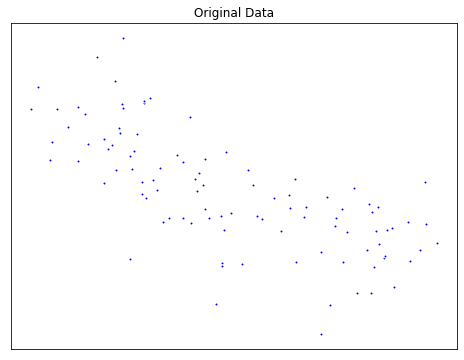

In [5]:
# Visualise our data using a scatter plot
fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111)
ax1.plot(X[:, 0], X[:, 1], 'w', markerfacecolor='b', marker='.')
ax1.title.set_text('Original Data')
ax1.set_yticks(())
ax1.set_xticks(())
plt.show()

In [6]:
# K means clustering using sklearn
n_clusters = 3
k_means = KMeans(n_clusters=3, init='k-means++', n_init=10).fit(X)

In [7]:
# group labels
k_means_labels = k_means.labels_
k_means_labels[0:5]

array([0, 1, 0, 2, 2])

In [8]:
# cluster centroid as determined by k means
k_means_centroids = np.around(k_means.cluster_centers_, decimals=2)
print('The cluster centroids were {}, {} and {}.'.format(centroids[0], centroids[1], centroids[2]))
print('The cluster centroids determined by k means were {}, {} and {}.'.format(k_means_centroids[0], k_means_centroids[1], k_means_centroids[2]))

The cluster centroids were [1 3], [4 2] and [-1  5].
The cluster centroids determined by k means were [4.19 1.93], [0.95 2.9 ] and [-1.23  5.09].


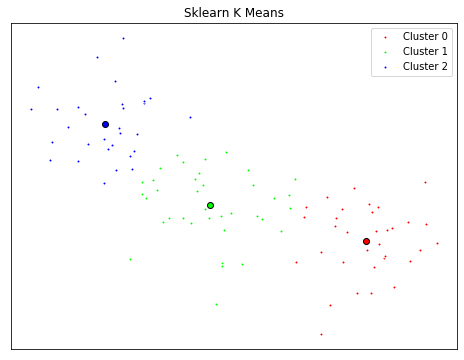

In [9]:
# visualise the clusters
fig2 = plt.figure(figsize=(8, 6))
ax2 = fig2.add_subplot(111)
plot_colors = np.eye(3)
clusters = list(range(n_clusters))

for cluster, color in zip(clusters, plot_colors):
    cluster_center = k_means_centroids[cluster]
    points = X[k_means_labels == cluster]
    ax2.plot(points[:, 0], points[:, 1], 'w', markerfacecolor=color, marker='.', label='Cluster {}'.format(cluster))
    ax2.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=color, markeredgecolor='k', markersize=6)

ax2.title.set_text('Sklearn K Means')
ax2.legend(loc='best')
ax2.set_yticks(())
ax2.set_xticks(())
plt.show()

In [10]:
# Here is my implementation of the K means clustering class
class K_Means:
    
    def __init__(self, n_clusters, n_iter=10):
        """init method
        :arg n_clusters: int
        :arg n_iter: int
        """
        self.n_clusters = n_clusters
        self.n_iter = n_iter

    def fit(self, X):
        """this method groups input data into clusters.
        :arg X: n by m ndarray where n is the number of data points and m is the number of features
        :return self: K_Means instance which called this method
        """
        # dimensions of X
        n_points, n_features = X.shape
        
        # number of clusters exceeds the number of points
        if self.n_clusters >= n_points:
            self.labels_ = np.arange(n_points)
            self.cluster_centers_ = X
            self.inertia_ = 0
            return self
        
        # initialise centers, labels and inertia (will store the best values)
        cluster_centers, cluster_labels, lowest_inertia = None, None, float('inf')
        
        # n_iter iterations will be run with random centroids
        for iteration in range(self.n_iter):

            # randomly select initial centroids
            centroids = self.select_random_centers(X)
            prev_labels = np.zeros(n_points)
            curr_labels = np.ones(n_points)
            
            # stop iteration when none of the points change clusters between iterations
            while not np.all(prev_labels == curr_labels):
                
                # update labels
                prev_labels = curr_labels
                curr_labels = np.ones(n_points)

                # locate the closest centroid to each point
                for n in range(n_points):
                    curr_labels[n] = self.locate_closest_centroid(X[n], centroids)

                # recalculate the position of centroids
                for n in range(self.n_clusters):
                    cluster_members = X[curr_labels == n]
                    centroids[n] = np.mean(cluster_members, axis=0)

            # calculate the inertia of the current cluster formation
            inertia = self.calculate_inertia(X, curr_labels)
            if inertia < lowest_inertia:
                cluster_centers, cluster_labels, lowest_inertia = centroids, curr_labels, inertia

        # creating clustering attributes
        self.labels_ = cluster_labels.astype(int)
        self.cluster_centers_ = cluster_centers
        self.inertia_ = lowest_inertia
        return self

    def select_random_centers(self, X):
        """this methods selects random data points as initial cluster centers.
        :arg X: n by m ndarray where n is the number of data points and m is the number of features
        :return: ndarray of dimensions self.n_clusters by X.shape[1]
        """
        random_index = []
        indices = list(range(len(X)))
        
        while len(random_index) < self.n_clusters:
            # selects an index at random
            sample = choice(indices)
            random_index.append(sample)
            
            # remove the chosen index to avoid duplicates
            indices.remove(sample)
            
        # return the points at the randomly selected indices
        return X[random_index]

    def calculate_inertia(self, X, labels):
        """this method calculates the inertia of a clustering formation.
        :arg X: n by m ndarray where n is the number of data points and m is the number of features
        :arg labels: 1darray denoting the cluster that each point of X belongs to
        :return inertia: a float denoting the inertia (error) of the clustering of X using labels
        """
        inertia = 0
        for n in range(self.n_clusters):
            # points which belong to the current cluster
            cluster_members = X[labels == n]
            n_members = len(cluster_members)
            
            # inertia = 0 if there are at most 1 point in the cluster
            if n_members <= 1:
                continue
            
            # calculate the squared distance between every point in the cluster 
            sub = 0
            for i in range(n_members - 1):
                for j in range(i + 1, n_members):
                    sub += np.sum((cluster_members[i] - cluster_members[j]) ** 2)
            # add subtotal to total inertia 
            inertia += sub / n_members
        # return the total inertia
        return inertia

    def locate_closest_centroid(self, point, centroids):
        """this method locates the closest centroid to a given data point.
        :arg point: 1darray containing n features denoting the coordinates of the data point
        :arg centroids: ndarray of dimensions m by n where m is the number of centroids and n is the number of features
        :return closest_centroid: 1darray containing n features denoting the coordinates of the closest centroid.
        """
        min_dist = float('inf')
        closest_centroid = None
        for n in range(self.n_clusters):
            # calculate the distance between the point and a particular centroid
            centroid = centroids[n]
            dist = np.sum((centroid - point) ** 2)
            
            # replace the minimum distance if the new distance is closer
            if dist < min_dist:
                min_dist = dist
                closest_centroid = n
        # return the closest centroid to the data point
        return closest_centroid

In [11]:
# create an instance of our class
my_k_means = K_Means(3).fit(X)

In [12]:
# take a look at our labels
my_k_means_labels = my_k_means.labels_
my_k_means_labels[0:5]

array([0, 1, 0, 2, 2])

In [13]:
# compare our cluster centroids to sklearn's
my_k_means_centroids = np.around(my_k_means.cluster_centers_, decimals=2)
print('The cluster centroids determined by k means were {}, {} and {}.'.format(k_means_centroids[0], k_means_centroids[1], k_means_centroids[2]))
print('The cluster centroids determined by my k means were {}, {} and {}.'.format(my_k_means_centroids[0], my_k_means_centroids[1], my_k_means_centroids[2]))

The cluster centroids determined by k means were [4.19 1.93], [0.95 2.9 ] and [-1.23  5.09].
The cluster centroids determined by my k means were [4.19 1.93], [1.04 2.81] and [-1.12  4.98].


In [14]:
# compare our inertia (error) to sklearn's
my_k_means_inertia = my_k_means.inertia_
k_means_inertia = k_means.inertia_
print('The inertia calculated by sklearn library: {:.6f}'.format(k_means_inertia))
print('The inertia calculated by my K_Means class: {:.6f}'.format(my_k_means_inertia))

The inertia calculated by sklearn library: 152.999514
The inertia calculated by my K_Means class: 153.633923


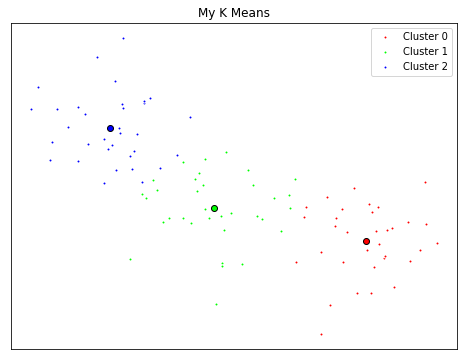

In [15]:
# visualise our clusters
# visualise the clusters
fig3 = plt.figure(figsize=(8, 6))
ax3 = fig3.add_subplot(111)
plot_colors = np.eye(3)
clusters = list(range(n_clusters))

for cluster, color in zip(clusters, plot_colors):
    cluster_center = my_k_means_centroids[cluster]
    points = X[my_k_means_labels == cluster]
    ax3.plot(points[:, 0], points[:, 1], 'w', markerfacecolor=color, marker='.', label='Cluster {}'.format(cluster))
    ax3.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=color, markeredgecolor='k', markersize=6)

ax3.title.set_text('My K Means')
ax3.legend(loc='best')
ax3.set_yticks(())
ax3.set_xticks(())
plt.show()